In [3]:
#Import packages
import os
import glob
import json
#from tqdm import tqdm

import nilearn
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix, run_glm
from nilearn.glm import fdr_threshold,threshold_stats_img
from nilearn.glm.contrasts import compute_contrast


from bids.layout import BIDSLayout, parse_file_entities

# import cortex
# from cortex import fmriprep

from nipype.interfaces.workbench.base import WBCommand
from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

import hcp_utils as hcp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

from PIL import Image

import first_level_sparse_scanning as flss 
import importlib


In [11]:
# space='MNI152NLin6Asym'

# nifti = glob.glob(f'../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-{run}*{space}*preproc*nii.gz')[0]
# events = glob.glob(f'/nese/mit/group/sig/om_projects/voice/bids/data/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-0{run}*events.tsv')

# task_json = open(f"../../task-{task}_bold.json")
# task_json=json.load(task_json)
# TR=task_json['RepetitionTime']

# #get the confounds to regress against for 1st level model
# selected_confounds=flss.get_confounds(sub,task,ses,run)

# glm = FirstLevelModel(t_r=TR, 
#                       noise_model='ar1',
#                       drift_model=None,
#                       standardize=False,
#                       hrf_model=None,
#                       high_pass=None)

# fitted_glm = glm.fit(nifti, events=events[0], confounds=selected_confounds)
# frame_times = fitted_glm.design_matrices_[0].index

In [5]:
root = '../../derivatives/events_sweep'
sub = 'voice880'
ses = '1'
task = 'nwr'
run = '1'

all_confounds = pd.read_csv(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')
len([col for col in all_confounds.columns if 'a_comp_cor' in col])

task_json = open(f"../../task-{task}_bold.json")
task_json=json.load(task_json)
TR = task_json['RepetitionTime']
DT = task_json['DelayTime']
original_events_file = f'{root}/sub-{sub}_ses-{ses}_task-{task}_run-0{run}_events.tsv'

ev = pd.read_table(original_events_file)
ev.onset = ev.onset + (TR-DT)
ev.duration = DT
custom_events = '../../derivatives/onset_duration_shift/test.tsv'
ev.to_csv(custom_events, sep="\t", index=False)
pd.read_table(custom_events).head()

# glob.glob(f'/nese/mit/group/sig/om_projects/voice/bids/data/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-0{run}*events.tsv')
#base_events = pd.read_table(events_file[0])

,onset,duration,trial_type,nonword
0,1.10,2.9,4,nuplarative
1,5.12,2.9,4,allotastry
2,9.13,2.9,5,ionificate
3,13.15,2.9,5,uninagable
4,17.17,2.9,Rest,NaN


In [6]:
importlib.reload(flss)

bids_item = [parse_file_entities(original_events_file)]

return_type = 'z_score'
#contrast_maps = flss.convolve_sparse_scan_glm_with_cifti(bids_item, return_type, [custom_events])
fit_glm = flss.convolve_sparse_scan_glm_with_cifti(bids_item, return_type, [custom_events])
#dm = flss.convolve_sparse_scan_glm_with_cifti(bids_item, return_type, [custom_events])

231024-13:32:45,833 nipype.interface INFO:
	 Setting dt = 110 ms

231024-13:32:45,836 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231024-13:32:45,836 nipype.interface INFO:
	 reg_scale: 43.1973
231024-13:32:45,839 nipype.interface INFO:
	 Setting dt = 110 ms

231024-13:32:45,840 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231024-13:32:45,840 nipype.interface INFO:
	 reg_scale: 43.1973
231024-13:32:45,842 nipype.interface INFO:
	 Setting dt = 110 ms

231024-13:32:45,844 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231024-13:32:45,844 nipype.interface INFO:
	 reg_scale: 43.1973
231024-13:32:45,846 nipype.interface INFO:
	 Setting dt = 110 ms

231024-13:32:45,848 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231024-13:32:45,848 nipype.interface INFO:
	 reg_scale: 43.1973
231024-13:32:45,850 nipype.interface INFO:
	 Setting dt = 110 ms

231024-13:32:45,852 nipype.interface INFO:
	 response sum: 1.0000 max: 0.0231
231024-13:32:45,852 nipy

In [10]:
fit_glm.pvalues

ValueError: shapes (42,91282) and (42,91282) not aligned: 91282 (dim 1) != 42 (dim 0)

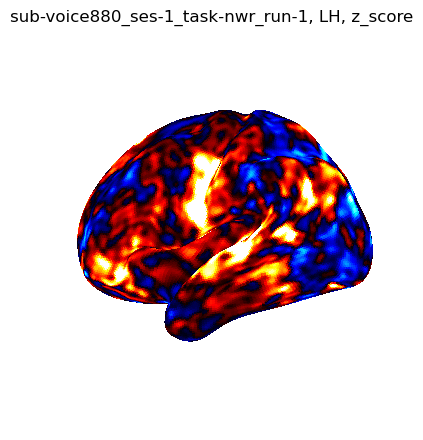

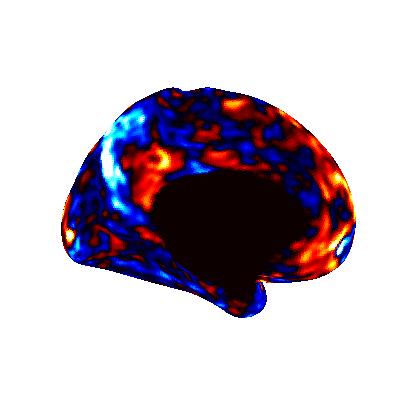

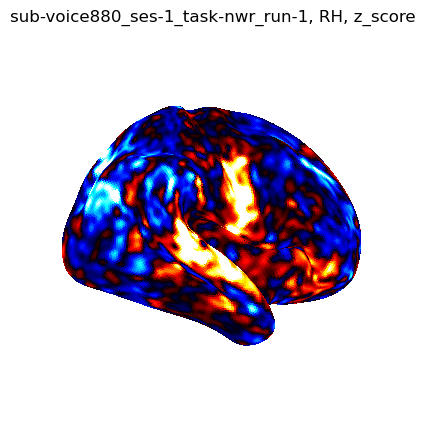

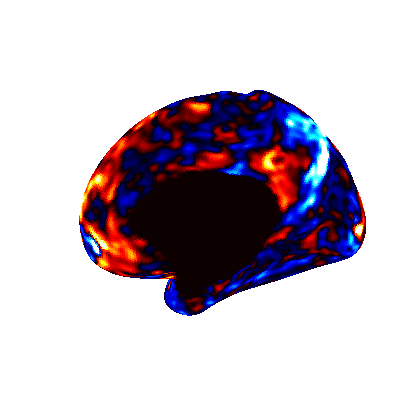

In [76]:
vmax = 3
for c in contrast_maps.columns:
    
    title = c
    nplot.plot_surf_stat_map(
        hcp.mesh.inflated, hcp.cortex_data(contrast_maps[c]), hemi='left', #threshold=thresholds[c],
        symmetric_cbar = False,
        colorbar=False,
        title = f'{title}, LH, {return_type}', #output_file=f'{root}/{c}_hemi-LH_view-lateral.png',
        title_font_size=30, vmax = vmax,
        bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
        hcp.mesh.inflated_left, hcp.left_cortex_data(contrast_maps[c]), view= 'lateral',
        hemi='right', #threshold=thresholds[c],
        symmetric_cbar = False, #output_file=f'{root}/{c}_hemi-LH_view-medial.png',
        colorbar=False, vmax = vmax,  
        bg_map=hcp.mesh.sulc_left)

    nplot.plot_surf_stat_map(
        hcp.mesh.inflated, hcp.cortex_data(contrast_maps[c]), hemi='right', #threshold=thresholds[covariate],
        symmetric_cbar = False, #output_file=f'{root}/{c}_hemi-RH_view-lateral.png',
        colorbar=False,
        title = f'{title}, RH, {return_type}', vmax = vmax,
        bg_map=hcp.mesh.sulc)

    nplot.plot_surf_stat_map(
        hcp.mesh.inflated_right, hcp.left_cortex_data(contrast_maps[c]), view= 'lateral',
        hemi='left', #threshold=thresholds[covariate],
        symmetric_cbar = False, #output_file=f'{root}/{c}_hemi-RH_view-medial.png',
        colorbar=False, vmax = vmax,
        bg_map=hcp.mesh.sulc_right)
    
    nplot.show()